In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural@v1.5.4
      !pip install lavavu-osmesa==1.8.32 geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer, RotationAnglePlotter
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_data = r"./data"
path_DEM = r"./data/dem.tif"

In [3]:
updated_data = pd.read_csv(os.path.join(path_data, "./LoopStructural_data/updated_data_SB1.csv"))
updated_ori = pd.read_csv(os.path.join(path_data, "./LoopStructural_data/updated_ori_SB1.csv"))

In [4]:
origin = [278590.2226191017543897,6598684.8566970974206924, -40000]
maximum = [349951.3870649862801656,6654101.1388352485373616, 5000]

In [6]:
# contacts
contacts = gpd.read_file(os.path.join(path_data, "contacts/contacts_SB1.shp"))
contacts = pd.DataFrame({'X': contacts.geometry.x, 
                         'Y': contacts.geometry.y, 
                         'Z': contacts['DEM'], 
                         'name': contacts['NAME']})

contacts = contacts.dropna().reset_index()

In [7]:
#strati_order

order = [
    ("Group_0", ['Granitoid', 'Lower_Mafics', 'Middle_Mafics', 'Upper_Mafics', 'Lower_BF']), 
    ("Group_1", ['Late_Basin'])
]

order

[('Group_0',
  ['Granitoid', 'Lower_Mafics', 'Middle_Mafics', 'Upper_Mafics', 'Lower_BF']),
 ('Group_1', ['Late_Basin'])]

# measurements

In [12]:
ig_lyr = gpd.read_file(
    os.path.join(path_data, "beddings/011_igneous_layering_with_formations.shp")).explode(ignore_index=True, 
                                                                                          index_parts=True)

measurements_df = pd.DataFrame({
    'X': ig_lyr.geometry.x, 
    'Y': ig_lyr.geometry.y,
    'Z': ig_lyr.DEM, 
    'name': ig_lyr.Name, 
    'strike': ig_lyr.STRIKE, 
    'dip':ig_lyr.DIP, 
    'polarity':1
})

In [13]:
beddings = gpd.read_file(
    os.path.join(path_data, "beddings/033_beddings_with_verticals_with_formations.shp")).explode(ignore_index=True, 
                                                                                                 index_parts=True)

measurements_df1 = pd.DataFrame({
    'X': beddings.geometry.x, 
    'Y': beddings.geometry.y,
    'Z': beddings.DEM, 
    'name': beddings.Name, 
    'strike': beddings.STRIKE, 
    'dip': beddings.DIP, 
    'polarity':1
})

In [14]:
met_foliations_s0 = gpd.read_file(
    os.path.join(path_data, "beddings/04_met_foliation_s0_with_formations.shp")).explode(ignore_index=True, 
                                                                                         index_parts=True)

measurements_df2 = pd.DataFrame({
    'X': met_foliations_s0.geometry.x, 
    'Y': met_foliations_s0.geometry.y,
    'Z': met_foliations_s0.DEM, 
    'name': met_foliations_s0.Name, 
    'strike': met_foliations_s0.STRIKE, 
    'dip': met_foliations_s0.DIP, 
    'polarity':1
})

In [15]:
# Late_Basins_measurements

late_basins_measurements = gpd.read_file("data/beddings/late_basins_measurements.shp").explode(ignore_index=True, index_parts=True)

late_basins_measurements = pd.DataFrame({
    'X': late_basins_measurements.geometry.x, 
    'Y': late_basins_measurements.geometry.y, 
    'Z': late_basins_measurements.DEM, 
    'name': late_basins_measurements.Name, 
    'strike': late_basins_measurements.STRIKE, 
    'dip': late_basins_measurements.DIP, 
    'polarity': 1 
}
)



In [16]:
measurements_df = pd.concat(
    [measurements_df, measurements_df1, measurements_df2, late_basins_measurements]
) 

In [17]:
# match measurements names with contacts names
measurements_df = measurements_df.replace('Ora Banda Gabbro', 'OraBanda_Gabbro')
measurements_df = measurements_df.replace('Mount_Pleasant_Gabbro', 'Mts_Gabbros')
measurements_df = measurements_df.replace('Mount_Ellis_Gabbro', 'Mts_Gabbros')
measurements_df = measurements_df.replace('Granitoids', 'Granitoid')

In [18]:
# remove 90degrees values
measurements_df = measurements_df.reset_index(drop=True)
measurements_df = measurements_df[measurements_df['dip']<75]
measurements_df = measurements_df[measurements_df['dip']!=-99]
measurements_df = measurements_df.reset_index(drop=True)

In [19]:
thickness = {
    
    'Granitoid': 3000,
    'Lower_Mafics': 1000, ##### CHANGED FROM 2000 
    'Middle_Mafics': 2407, 
    'Upper_Mafics': 3066, 
    'Mts_Gabbros': 1732, 
    'OraBanda_Gabbro': 1575, 
    'Lower_BF': 2349, 
    'Late_Basin': 1500

}

In [20]:
processor = ProcessInputData(
    contacts=contacts,
    contact_orientations=measurements_df,
    thicknesses=thickness,
    stratigraphic_order=order,
    origin=origin,
    maximum=maximum, 
    fault_locations = updated_data, 
    fault_orientations = updated_ori
)

                This will result in only a fault surface, no displacement on older features


In [23]:
# add the fold to the processor

fold = gpd.read_file(os.path.join(path_data, "folds/fold.shp"))
fold['X'] = fold.geometry.x
fold['Y'] = fold.geometry.y

import math

strikes = []

for i in range(0, len(fold) - 1):
    x1, y1 = fold['X'][i], fold['Y'][i]
    x2, y2 = fold['X'][i + 1], fold['Y'][i + 1]
    strikes.append(math.degrees(math.atan2((x2 - x1), (y2 - y1))))

strikes.append(338 - 180)
fold['strikes'] = strikes

fold = pd.DataFrame({
    'X': fold['X'],
    'Y': fold['Y'],
    'Z': fold['dem'],
    'strike': fold['strikes'],
    'dip': 90
})

from LoopStructural.utils import strike_dip_vector

fold_df = pd.DataFrame(strike_dip_vector(strike=fold['strike'] + 180,
                                      dip=fold['dip']),
                    columns=['nx', 'ny', 'nz'])

fold['nx'] = fold_df['nx']
fold['ny'] = fold_df['ny']
fold['nz'] = fold_df['nz']

fold['feature_name'] = 's1'
fold['val'] = 0
fold['coord'] = 0

data_test = pd.concat([processor.data, fold])

mx = fold['X'].mean()
my = fold['Y'].mean()
mz = fold['Z'].mean()

a = pd.DataFrame(pd.Series({'X': mx, 
             'Y': my, 
             'Z': mz, 
            'feature_name': 's1',
             'val':1,
             'coord':1})).T

data_test = pd.concat([data_test, a])

In [24]:
data_test["X"] = pd.to_numeric(data_test["X"])
data_test["Y"] = pd.to_numeric(data_test["Y"])
data_test["Z"] = pd.to_numeric(data_test["Z"])
data_test["val"] = pd.to_numeric(data_test["val"])
data_test["polarity"] = pd.to_numeric(data_test["polarity"])
data_test["dip"] = pd.to_numeric(data_test["dip"])
data_test["strike"] = pd.to_numeric(data_test["strike"])
data_test["coord"] = pd.to_numeric(data_test["coord"])
data_test["nx"] = pd.to_numeric(data_test["nx"])
data_test["ny"] = pd.to_numeric(data_test["ny"])
data_test["nz"] = pd.to_numeric(data_test["nz"])
data_test["gx"] = pd.to_numeric(data_test["gx"])
data_test["gy"] = pd.to_numeric(data_test["gy"])
data_test["gz"] = pd.to_numeric(data_test["gz"])

In [26]:
model = GeologicalModel(origin = origin, maximum=maximum)
model.data = data_test

# model.nsteps = [100, 100, 200]
model.stratigraphic_column = processor.stratigraphic_column
model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM) 

model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)
# model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True), 

S1 = model.create_and_add_fold_frame('s1',
                                     nelements=1e4, 
                                     buffer=0.3,
                                     damp=True)

model.update()

# view = LavaVuModelViewer(model)
# view.add_scalar_field(S1[0])
# view.add_scalar_field(S1[1])
# view.interactive()

ERROR: 2023-03-21 15:21:55,335: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-03-21 15:21:55,336: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-03-21 15:21:55,336: _base_geological_feature.py:73 -- Model not set


  0%|          | 0/6 [00:00<?, ?it/s]

ERROR: 2023-03-21 15:22:05,568: _geological_feature_builder.py:212 -- Not enough constraints for scalar field add more


In [31]:
fold_weights = {'fold_orientation': 10, 
                'fold_axis_w': 10, 
#                 'fold_regularisation': [0.1, 0.1, .1], 
                'fold_normalisation': 0.1, 
                'fold_norm': 2.5, #length of the norm
                'step': 150}

S0 = model.create_and_add_folded_foliation('Group_0',
                                            limb_wl= 20000, 
                                            fold_frame=S1,
                                            fold_weights = fold_weights,
                                            av_fold_axis=True, # 
                                            nelements=1e4,
                                            buffer = 0.1, 
                                            solver='cg', 
                                            cpw = 0.1, npw = 0.1
                                           )
model.create_and_add_foliation("Group_1", nelements = 1e4, solver = 'cg')
model.update()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]


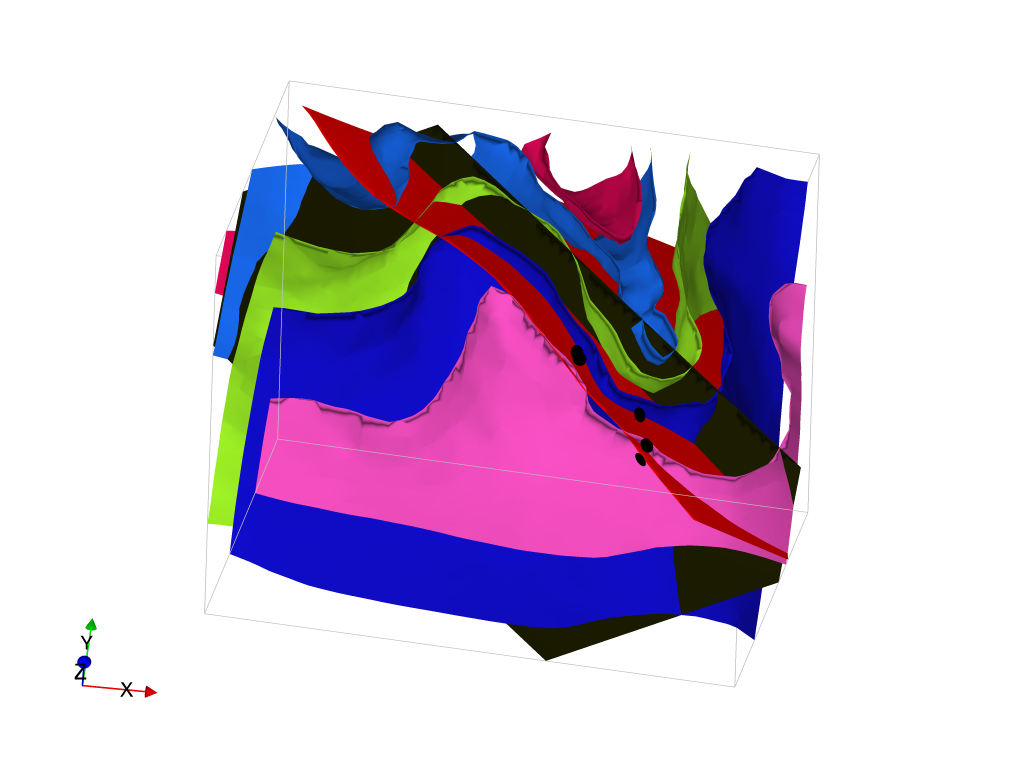

In [33]:
view = LavaVuModelViewer(model)

all_names = []
all_values = []

# view.nsteps = [100,100,300]


# colores = [['#e0d841'], 
#            ['#b5dfae'], 
#            ['#6cb464'],
#            ['#17632e'], 
#            ['#f7dff3']   
#            ]

view.add_model_surfaces()
# view.add_model()
# view.add_data(model['Group_0'])
view.add_data(model['Group_1'])
# view.add_isosurface(model['Group_1'], nslices = 10)

# for n, vals in model.stratigraphic_column['Group_0'].items():
#     all_names.append(n)
#     all_values.append(vals['min'])
    
# for i, valuey in enumerate(all_values):
#     view.add_isosurface(model['Group_0'], value = valuey, 
#                    colours = colores[i], 
#                     names = [all_names[i]])

# view.add_isosurface(model['F1'], value = 0, colours = ['darkred'], opacity = 0.6)
# view.add_isosurface(model['Zuleika Fault'], value = 0, colours = ['black'], opacity = 0.6)
# view.add_isosurface(model['Boorara Fault'], value = 0, colours = ['grey'], opacity = 0.6)

view.rotation = [-32.32075119018555, 9.636723518371582, -7.883737087249756]
view.display()

In [ ]:
# the Late_basin is completely vertical. Means that the anticline needs to be added. 
